In [1]:
import matplotlib.pyplot as plt
from aerobot.utils import RESULTS_PATH, load_results_dict, DATA_PATH, FIGURES_PATH, CONTIGS_PATH
from aerobot.plot import plot_configure_mpl, PRETTY_NAMES
from aerobot.dataset import FeatureDataset
import pandas as pd
from matplotlib.gridspec import GridSpec
from scipy.stats import linregress
import numpy as np
from Bio import SeqIO
import os
from typing import List, Dict, Tuple
import scipy.optimize
import glob 

%load_ext autoreload 
%autoreload 2 

plot_configure_mpl(figure_height=2) # Want at least one color for each genome have results for. 

In [14]:
CONTIGS_PATH = os.path.join(DATA_PATH, 'contigs')
# These are the feature types which I currently have results for. 
feature_types = ['nt_3mer', 'nt_4mer', 'nt_5mer']

In [15]:
# Want to get the final model accuracies for adding to the titles. 
test_accs = dict()
for feature_type in feature_types:
    results = load_results_dict(os.path.join(RESULTS_PATH, f'train_nonlinear_{feature_type}_ternary.json'))
    test_acc = results['test_acc']
    print(f'Final testing accuracy for {feature_type}: {test_acc}')
    test_accs[feature_type] = int(test_acc * 100)

Final testing accuracy for nt_3mer: 0.7186324315969514
Final testing accuracy for nt_4mer: 0.7711036433501541
Final testing accuracy for nt_5mer: 0.781867495084243


In [16]:
def parse_contig_id(contig_id:str) -> Dict:
    '''Parse a contig ID, which is of the form {genome_id}_{contig_size}_{contig_number}'''

    genome_id_prefix, genome_id_num, contig_size, contig_num = contig_id.split('_')
    contig_size = int(contig_size)
    genome_id = f'{genome_id_prefix}_{genome_id_num}'
    return {'id':contig_id, 'contig_size':contig_size, 'genome_id':genome_id}

In [17]:
# Load the correct labels for each genome, as well as other metadata. Use the metadata stored in the datasets,
# as this contains extra information (like contig size).
genome_metadata = pd.read_csv(os.path.join(CONTIGS_PATH, 'genome_metadata.csv'), index_col=0)
genome_metadata['genome_id'] = genome_metadata.index
# Organize the contigs results into DataFrames for plotting. 
contigs_results = dict() 

for feature_type in feature_types:
    predictions = pd.read_csv(os.path.join(RESULTS_PATH, f'predict_contigs_nonlinear_{feature_type}_ternary.csv'), index_col=0)
    metadata = pd.DataFrame([parse_contig_id(contig_id) for contig_id in predictions.index])
    metadata = metadata.merge(genome_metadata, on='genome_id', how='left')
    metadata = metadata.set_index('id')

    predictions = predictions.merge(metadata, how='left', left_index=True, right_index=True)
    # We want to assess contig predictions based on the whole-genome predictions. 
    # "correct" column indicates whether or not the contig prediction matches the genome prediction. 
    predictions['correct'] = predictions.prediction == predictions[f'{feature_type}_prediction']
    # predictions['correct'] = predictions.prediction == predictions.physiology.str.lower()
    contigs_results[feature_type] = predictions


In [18]:
nt_5mer_results = contigs_results['nt_5mer']
print('Number of aerobes:', np.sum(nt_5mer_results.physiology.str.match('Aerobe')))
print('Number of facultative:', np.sum(nt_5mer_results.physiology.str.match('Facultative')))
print('Number of anaerobes:', np.sum(nt_5mer_results.physiology.str.match('Anaerobe')))
print()
print('Number of aerobes:', np.sum(nt_5mer_results.physiology.str.match('Aerobe')) / len(nt_5mer_results))
print('Number of facultative:', np.sum(nt_5mer_results.physiology.str.match('Facultative')) / len(nt_5mer_results))
print('Number of anaerobes:', np.sum(nt_5mer_results.physiology.str.match('Anaerobe')) / len(nt_5mer_results))

Number of aerobes: 187984
Number of facultative: 42695
Number of anaerobes: 65163

Number of aerobes: 0.6354202581107483
Number of facultative: 0.14431689888521576
Number of anaerobes: 0.22026284300403595


In [19]:
genome_sizes = []
# Get the average size of the downloaded genomes. 
for file in os.listdir(os.path.join(CONTIGS_PATH, 'genomes')):
    genome = [str(record.seq) for record in SeqIO.parse(os.path.join(CONTIGS_PATH, 'genomes', file), 'fasta')]
    genome = ''.join(genome)
    genome_sizes.append(len(genome))
print('Mean genome size:', np.mean(genome_sizes))


Mean genome size: 3762205.180579216


In [35]:
from sklearn.metrics import balanced_accuracy_score

for contig_size, contig_size_df in contigs_results['nt_5mer'].groupby('contig_size'):
    labels = contig_size_df.physiology.str.lower().values
    y_pred = contig_size_df.prediction.values 

    print(f'Balanced accuracy score for contigs of size {contig_size}:', balanced_accuracy_score(labels, y_pred))

    for label, label_df in contig_size_df.groupby('physiology'):
        label = label.lower()
        y_pred = label_df.prediction.values
        print(f'\tAccuracy on {label}:', np.sum(y_pred == label) / len(label_df))

Balanced accuracy score for contigs of size 2000: 0.3333333333333333
	Accuracy on aerobe: 1.0
	Accuracy on anaerobe: 0.0
	Accuracy on facultative: 0.0
Balanced accuracy score for contigs of size 5000: 0.3333333333333333
	Accuracy on aerobe: 1.0
	Accuracy on anaerobe: 0.0
	Accuracy on facultative: 0.0
Balanced accuracy score for contigs of size 10000: 0.3333333333333333
	Accuracy on aerobe: 1.0
	Accuracy on anaerobe: 0.0
	Accuracy on facultative: 0.0
Balanced accuracy score for contigs of size 50000: 0.3333333333333333
	Accuracy on aerobe: 1.0
	Accuracy on anaerobe: 0.0
	Accuracy on facultative: 0.0


In [3]:
dataset = FeatureDataset(os.path.join(CONTIGS_PATH, 'datasets.h5'), feature_type='nt_3mer')
dataset.features

,CCT,CTG,TGC,GCA,CAA,AAA,AAT,ATA,TAA,ATC,...,TCG,GAT,GGG,GGC,GGA,AGC,CGG,GCC,CGT,GCT
<built-in function id>,0.008008,0.012012,0.009009,0.008008,0.021522,0.046046,0.034034,0.033534,0.025025,0.014014,...,0.003003,0.026527,0.004004,0.006006,0.020521,0.011512,0.004505,0.005506,0.005506,0.012012
<built-in function id>,0.015516,0.021522,0.016016,0.015015,0.031031,0.051552,0.030030,0.021021,0.018519,0.021021,...,0.008008,0.015015,0.006006,0.009510,0.011011,0.015015,0.005506,0.009510,0.006507,0.017017
<built-in function id>,0.004004,0.012012,0.010010,0.008509,0.021522,0.053053,0.033534,0.023023,0.025025,0.013514,...,0.010010,0.021522,0.003003,0.005005,0.017518,0.014515,0.004505,0.006507,0.010010,0.014014
<built-in function id>,0.011512,0.019520,0.012513,0.021021,0.043043,0.025025,0.029029,0.025025,0.015516,0.020521,...,0.006507,0.016517,0.005506,0.010511,0.014515,0.017017,0.005506,0.010010,0.009009,0.013514
<built-in function id>,0.005005,0.022523,0.017518,0.013013,0.020521,0.048048,0.027027,0.013013,0.023023,0.022022,...,0.020020,0.022022,0.002002,0.003504,0.013013,0.012513,0.004004,0.002503,0.022523,0.022022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
<built-in function id>,0.015161,0.019041,0.014821,0.012861,0.025101,0.032401,0.023021,0.021121,0.019881,0.020221,...,0.008080,0.016481,0.005160,0.009240,0.009460,0.016341,0.003920,0.009740,0.008080,0.018621
<built-in function id>,0.014181,0.015801,0.012961,0.012120,0.027341,0.042902,0.027921,0.024081,0.022741,0.019861,...,0.007480,0.016801,0.004780,0.007440,0.011000,0.014141,0.004120,0.008720,0.006180,0.014681
<built-in function id>,0.012020,0.014221,0.013461,0.013441,0.024321,0.037001,0.023641,0.017081,0.017381,0.016741,...,0.008940,0.021261,0.008040,0.010140,0.017821,0.016421,0.005720,0.008580,0.008360,0.016381
<built-in function id>,0.016161,0.017081,0.013101,0.014681,0.025941,0.027861,0.021761,0.019341,0.018561,0.020041,...,0.009160,0.016441,0.004540,0.008740,0.009620,0.016041,0.005580,0.008880,0.010280,0.015561


# SI Figure 7 


In [46]:
dataset.metadata

,contig_size,genome_id,Class,physiology,nt_3mer_prediction,nt_4mer_prediction,nt_5mer_prediction
<built-in function id>,NaN,NaN,NaN,NaN,NaN,NaN,NaN
<built-in function id>,NaN,NaN,NaN,NaN,NaN,NaN,NaN
<built-in function id>,NaN,NaN,NaN,NaN,NaN,NaN,NaN
<built-in function id>,NaN,NaN,NaN,NaN,NaN,NaN,NaN
<built-in function id>,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
<built-in function id>,NaN,NaN,NaN,NaN,NaN,NaN,NaN
<built-in function id>,NaN,NaN,NaN,NaN,NaN,NaN,NaN
<built-in function id>,NaN,NaN,NaN,NaN,NaN,NaN,NaN
<built-in function id>,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
def plot_si_figure_6(contigs_results:Dict[str, pd.DataFrame], fig:plt.Figure=None, grids:List[GridSpec]=None):
    '''Plot the results of evaluating trained Nonlinear classifiers on contigs. The contigs are generated using closed
    genomes from the testing dataset, for which we have known labels.'''
    axes = []
    for i, feature_type in enumerate(feature_types):
        ax = fig.add_subplot(grids[i])

        # Extract the results for the specified feature type. 
        results = contigs_results[feature_type]
        
        labels, handles = [],[]
        # Group the results according to the true label of the genome...
        for label, label_df in results.groupby('physiology'):
            labels.append(label.lower())
            
            x_vals, y_vals = [], []
            for contig_size in results.contig_size.unique():
                contig_size_df = label_df[label_df.contig_size == contig_size]
                x_vals.append(contig_size)
                y_vals.append(contig_size_df.correct.mean())
                errs = contig_size_df.correct.std() / np.sqrt(len(contig_size_df))
            # x_vals.append(3000000)
            # y_vals.append(1)
            ax.errorbar(x_vals, y_vals, yerr=errs, lw=0.7)
            handles.append(ax.scatter(x_vals, y_vals, s=10, linewidths=0.2))
            
        ax.set_xlabel('contig size')
        ax.set_yticks(np.arange(0.1, 1.0, 0.1), labels=[str(np.round(i, 2)) for i in np.arange(0.1, 1.0, 0.1)]) # Make tick labels consistent across plots.
        ax.set_ylabel('fraction matching genome prediction')
        ax.set_title(PRETTY_NAMES[feature_type] + f' ({test_accs[feature_type]}%)')
        axes.append(ax)
    
    axes[0].legend(handles=handles, labels=labels, loc='lower right')
        
    return axes # Return the axes for plotting the A, B, C labels. 



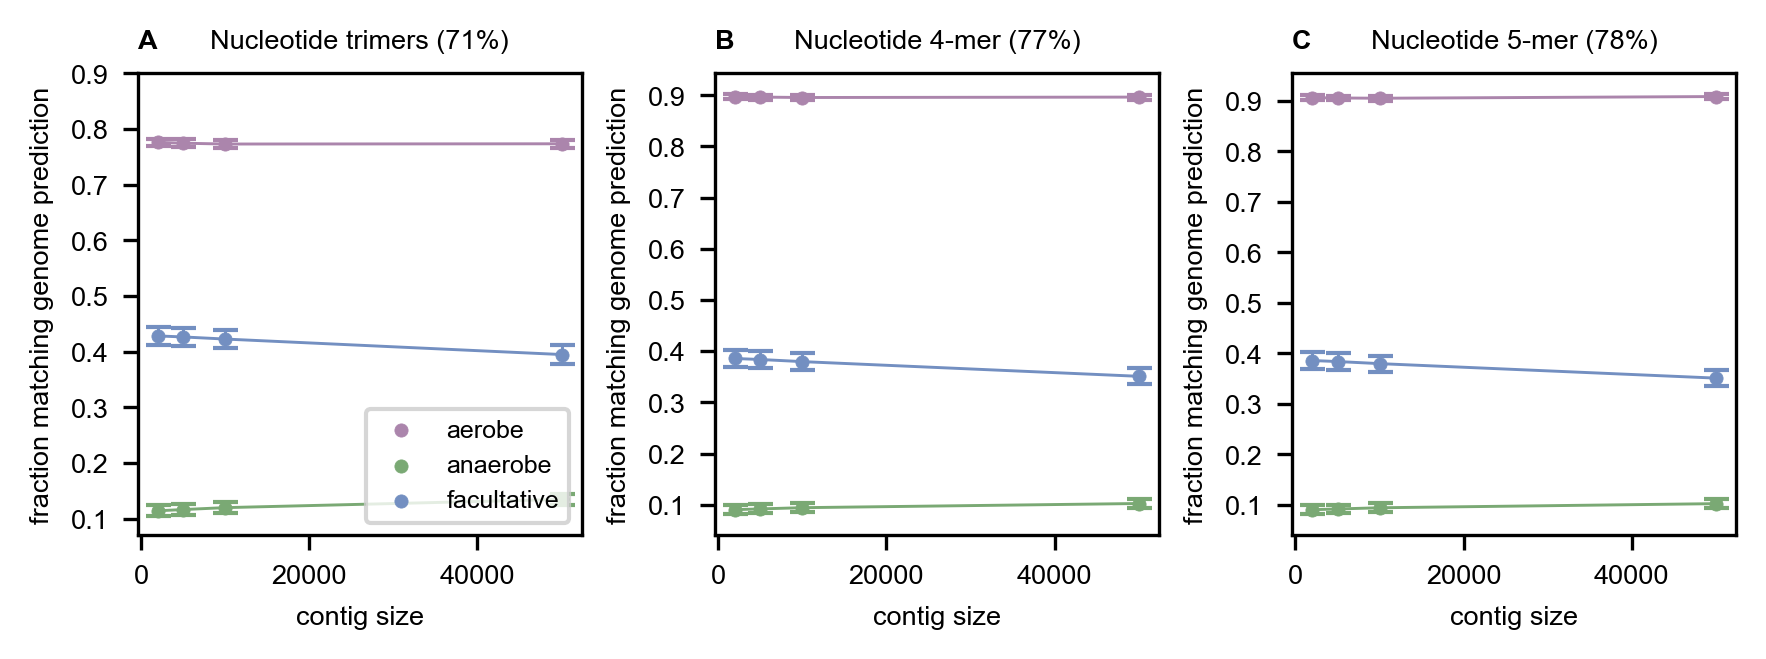

In [24]:
# n_rows, n_cols = 2, 3
n_cols = 3
fig = plt.figure()

grids = GridSpec(1, n_cols, wspace=0.3)
grids = [grids[0, i] for i in range(n_cols)] # + [grids[1, i] for i in range(n_cols)]

axes = plot_si_figure_6(contigs_results, fig=fig, grids=grids)

for ax, ax_label in zip(axes, 'ABC'):
    ax.set_title(ax_label, loc='left', fontweight='bold')

plt.savefig(os.path.join(FIGURES_PATH, 'si_fig7.png'), dpi=300, facecolor='w', bbox_inches='tight')
plt.show()